<a href="https://colab.research.google.com/github/julianencisoizquierdo/NLP_Python_UN_speeches/blob/main/NLP_Deriving_Insigths_from_the_UN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import warnings;
warnings.filterwarnings('ignore');

import pandas as pd
import numpy as np
import math
import re
import glob
import os
import sys
import json
import random
import pprint as pp
import textwrap
import sqlite3
import logging

import matplotlib
from matplotlib import pyplot as plt

import spacy
import nltk

from tqdm.auto import tqdm
tqdm.pandas()

import seaborn as sns
sns.set_style("darkgrid")

pd.options.display.max_columns = 30
pd.options.display.max_rows = 60
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_colwidth = 200
pd.set_option('display.html.use_mathjax', False)

plot_params = {'figure.figsize': (8, 4),
               'axes.labelsize': 'large',
               'axes.titlesize': 'large',
               'xtick.labelsize': 'large',
               'ytick.labelsize':'large',
               'figure.dpi': 100}

matplotlib.rcParams.update(plot_params)

In [3]:
BASE_DIR = '/content/drive/MyDrive/nlp'
os.chdir(BASE_DIR)

In [4]:
pd.options.display.max_colwidth = 150 ###
file = "un-general-debates-blueprint.csv.gz"
df = pd.read_csv(file)
df.sample(2, random_state=53)

,session,year,country,country_name,speaker,position,text
3871,51,1996,PER,Peru,Francisco Tudela Van Breughel Douglas,Minister for Foreign Affairs,"﻿At the outset, allow me,\nSir, to convey to you and to this Assembly the greetings\nand congratulations of the Peruvian people, as well as\ntheir..."
4697,56,2001,GBR,United Kingdom,Jack Straw,Minister for Foreign Affairs,"﻿Please allow me\nwarmly to congratulate you, Sir, on your assumption of\nthe presidency of the fifty-sixth session of the General\nAssembly.\nThi..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7507 entries, 0 to 7506
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   session       7507 non-null   int64 
 1   year          7507 non-null   int64 
 2   country       7507 non-null   object
 3   country_name  7507 non-null   object
 4   speaker       7480 non-null   object
 5   position      4502 non-null   object
 6   text          7507 non-null   object
dtypes: int64(2), object(5)
memory usage: 410.7+ KB


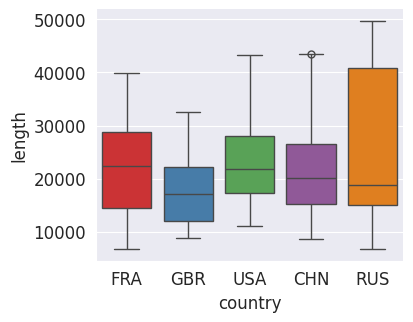

In [6]:
df['length'] = df['text'].apply(len)

where = df['country'].isin(['FRA','GBR','USA','CHN','RUS'])

g = sns.catplot(data=df[where], x="country", y="length", kind='box', palette='Set1')
g.fig.set_size_inches(4, 3)
g.fig.set_dpi(100)

<Axes: title={'center': 'Number of Countries'}, xlabel='year'>

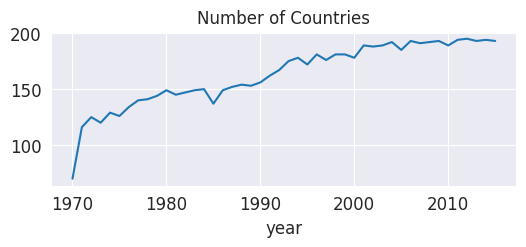

In [7]:
df.groupby(by=['year'])['country'].count().plot(title="Number of Countries", figsize=(6,2))

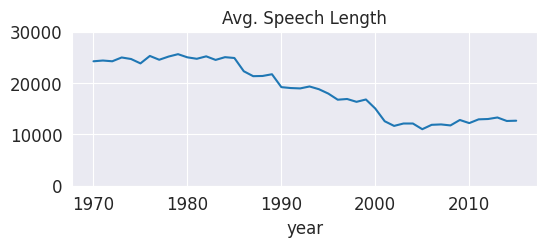

In [8]:
year_meanlength = df.groupby(['year'])['length'].mean()
year_meanlength.plot(title="Avg. Speech Length", ylim=(0,30000), figsize=(6,2));

In [9]:
nltk.download('stopwords')

stopwords = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
import regex as re

def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
  tokens = text
  for transform in pipeline:
      tokens = transform(tokens)
  return tokens

df['tokens'] = df['text'].progress_apply(prepare, pipeline=pipeline)

  0%|          | 0/7507 [00:00<?, ?it/s]

In [11]:
df['num_tokens'] = df['tokens'].progress_map(len)

  0%|          | 0/7507 [00:00<?, ?it/s]

In [12]:
from collections import Counter

def count_words(df, column='tokens', preprocess=None, min_freq=2):

  def update(doc):
      tokens = doc if preprocess is None else preprocess(doc)
      counter.update(tokens)

  counter = Counter()
  df[column].progress_map(update)

  freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
  freq_df = freq_df.query('freq >= @min_freq')
  freq_df.index.name = 'token'

  return freq_df.sort_values('freq', ascending=False)

freq_df = count_words(df)

  0%|          | 0/7507 [00:00<?, ?it/s]

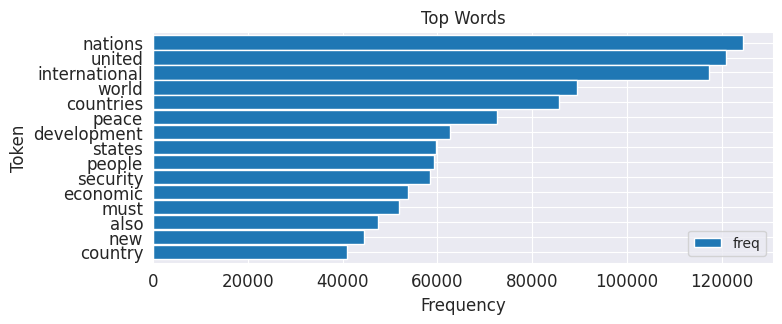

In [13]:
ax = freq_df.head(15).plot(kind='barh', width=0.95, figsize=(8,3))
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words');

In [14]:
from wordcloud import WordCloud ###
from collections import Counter ###

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

  wc = WordCloud(width=800, height=400,
                  background_color= "black", colormap="Paired",
                  max_font_size=150, max_words=max_words)

  if type(word_freq) == pd.Series:
      counter = Counter(word_freq.fillna(0).to_dict())
  else:
      counter = word_freq

  if stopwords is not None:
      counter = {token:freq for (token, freq) in counter.items()
                            if token not in stopwords}
  wc.generate_from_frequencies(counter)

  plt.title(title)

  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")

  0%|          | 0/192 [00:00<?, ?it/s]

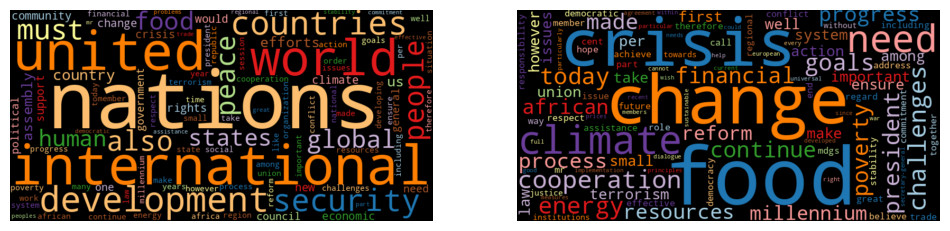

In [15]:
freq_2008_df = count_words(df[df['year']==2008])
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
wordcloud(freq_2008_df['freq'], max_words=100)

plt.subplot(1,2,2)
wordcloud(freq_2008_df['freq'], max_words=100, stopwords=freq_df.head(50).index)

In [16]:
def compute_idf(df, column='tokens', preprocess=None, min_df=2):

  def update(doc):
      tokens = doc if preprocess is None else preprocess(doc)
      counter.update(set(tokens))

  # count tokens
  counter = Counter()
  df[column].progress_map(update)

  # create data frame and compute idf
  idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
  idf_df = idf_df.query('df >= @min_df')
  idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
  idf_df.index.name = 'token'
  return idf_df

idf_df = compute_idf(df)

  0%|          | 0/7507 [00:00<?, ?it/s]

In [17]:
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

freq_df = freq_df.join(idf_df)
freq_df['tfidf'] = freq_df['freq'] * freq_df['idf']

  0%|          | 0/189 [00:00<?, ?it/s]

  0%|          | 0/189 [00:00<?, ?it/s]

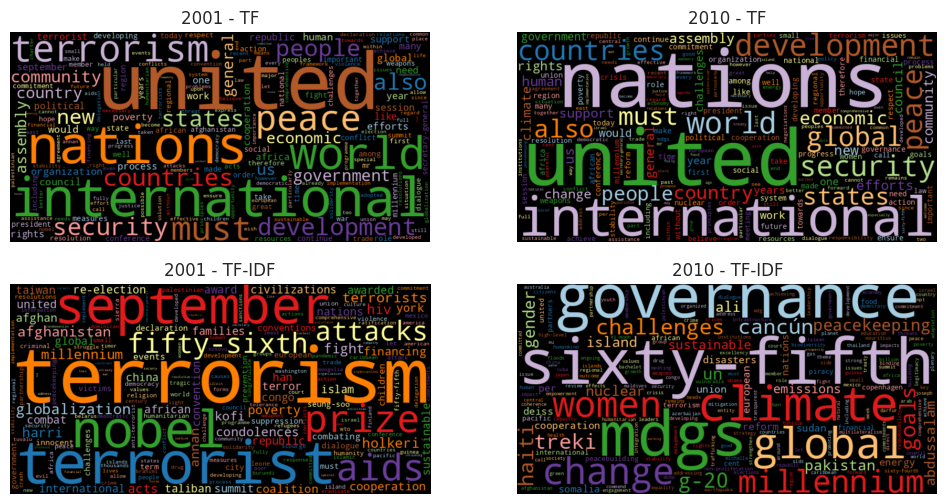

In [18]:
freq_2001 = count_words(df[df['year'] == 2001])
freq_2010 = count_words(df[df['year'] == 2010])

freq_2001['tfidf'] = freq_2001['freq'] * idf_df['idf']
freq_2010['tfidf'] = freq_2010['freq'] * idf_df['idf']

plt.figure(figsize=(12,6))

plt.subplot(2,2,1)
wordcloud(freq_2001['freq'], title='2001 - TF',
          stopwords=['twenty-fifth', 'twenty-five'])

plt.subplot(2,2,2)
wordcloud(freq_2010['freq'], title='2010 - TF',
          stopwords=['seventieth'])

plt.subplot(2,2,3)
wordcloud(freq_2001['tfidf'], title='2001 - TF-IDF',
          stopwords=['twenty-fifth', 'twenty-five', 'twenty', 'fifth'])

plt.subplot(2,2,4)
wordcloud(freq_2010['tfidf'], title='2010 - TF-IDF',
          stopwords=['seventieth'])

In [19]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [21]:
try:
  import textacy
except:
  !pip install textacy
  import textacy

In [22]:
def ngrams(tokens, n=2, sep=' ', stopwords=set()):

  return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])
            if len([t for t in ngram if t in stopwords])==0]

  0%|          | 0/7507 [00:00<?, ?it/s]

  0%|          | 0/7507 [00:00<?, ?it/s]

  0%|          | 0/7507 [00:00<?, ?it/s]

  0%|          | 0/7507 [00:00<?, ?it/s]

  0%|          | 0/193 [00:00<?, ?it/s]

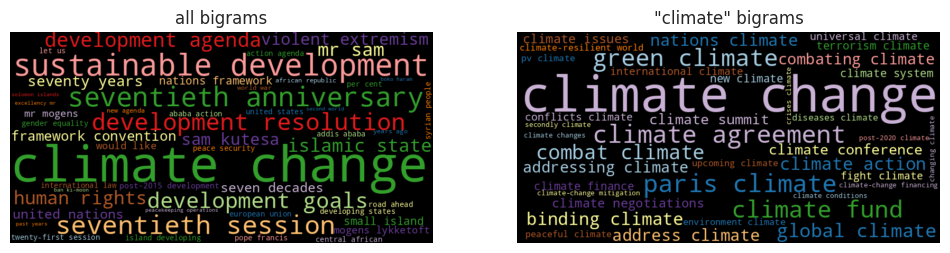

In [23]:
df['bigrams'] = df['text'].progress_apply(prepare, pipeline=[str.lower, tokenize])\
                            .progress_apply(ngrams, n=2, stopwords=stopwords)

idf_df = compute_idf(df)
idf_df = pd.concat([idf_df, compute_idf(df, 'bigrams', min_df=10)])

freq_df = count_words(df[df['year'] == 2015], 'bigrams')
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
wordcloud(freq_df['tfidf'], title='all bigrams', max_words=50)

plt.subplot(1,2,2)
where = freq_df.index.str.contains('climate')
wordcloud(freq_df[where]['freq'], title='"climate" bigrams', max_words=50)

In [24]:
def count_keywords(tokens, keywords):

  tokens = [t for t in tokens if t in keywords]
  counter = Counter(tokens)
  return [counter.get(k, 0) for k in keywords]

def count_keywords_by(df, by, keywords, column='tokens'):

  df = df.reset_index(drop=True) # if the supplied dataframe has gaps in the index
  freq_matrix = df[column].progress_apply(count_keywords, keywords=keywords)
  freq_df = pd.DataFrame.from_records(freq_matrix, columns=keywords)
  freq_df[by] = df[by] # copy the grouping column(s)

  return freq_df.groupby(by=by).sum().sort_values(by)

  0%|          | 0/7507 [00:00<?, ?it/s]

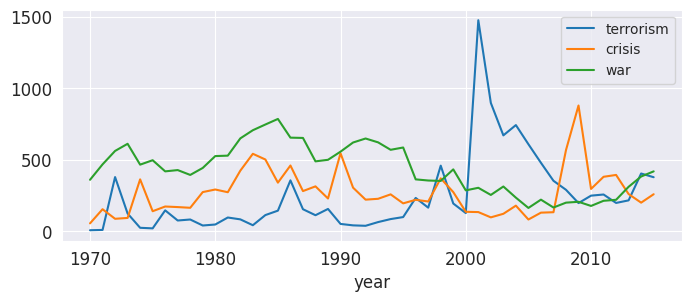

In [25]:
keywords = ['terrorism', 'crisis', 'war']

freq_df = count_keywords_by(df, by='year', keywords=keywords)

freq_df.plot(kind='line', figsize=(8, 3));

  0%|          | 0/7507 [00:00<?, ?it/s]

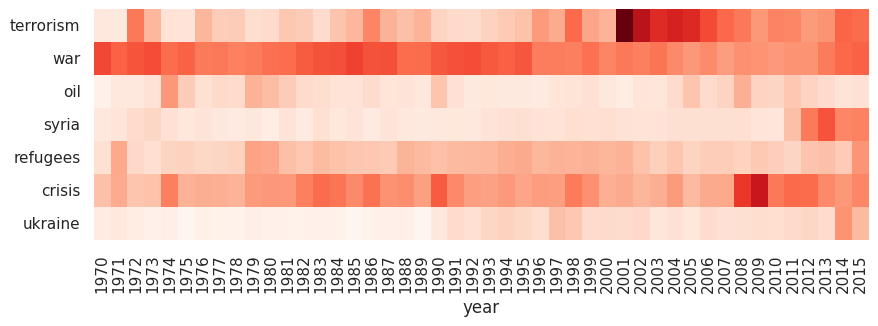

In [26]:
keywords = ['terrorism', 'war', 'oil',
            'syria', 'refugees', 'crisis', 'ukraine']

freq_df = count_keywords_by(df, by='year', keywords=keywords)

freq_df = freq_df.div(df.groupby('year')['num_tokens'].sum(), axis=0)

freq_df = freq_df.apply(np.sqrt)

plt.figure(figsize=(10, 3))
sns.set(font_scale=1)
sns.heatmap(data=freq_df.T,
            xticklabels=True, yticklabels=True, cbar=False, cmap="Reds")
sns.set(font_scale=1)